# $\textbf{Chemin d'accès et importations des librairies}$

In [ ]:
!pip install rasterio --quiet
%matplotlib inline

     |████████████████████████████████| 19.3 MB 35.2 MB/s 


In [ ]:
!pip install fiona --quiet

     |████████████████████████████████| 15.4 MB 39 kB/s 


In [ ]:
!pip install tqdm --quiet

In [ ]:
import os
import numpy as np
from numpy import savetxt
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
import fiona
from osgeo import gdal
from tqdm import tqdm
from typing import Tuple
import rasterio.mask

# Put your own path up to 'data' folder
os.chdir('/content/drive/My Drive/M2/Data Science/LakeNotLake/data') # Camille's path


FileNotFoundError: ignored

# $\color{red}{\textbf{Le Projet}}$
$\text{Détection de lacs sur des images thermiques MODIS autour du lac Tahoe}$

$\underline{\color{red}{\text{Objectif :}}}$
Il s'agit de détecter/classifier l'ensemble des lacs autour du lac Tahoe en Californie à partir d'images thermiques prises de jour comme de nuit par deux satellites : Acqua et Terra. La résolution spatiale est de 1 kilomètre (km) avec une grille de 1200 par 1200 km.


## $\underline{\color{darkorange}{\text{Visualisation des données}}}$

### $\text{Visualisation des noms}$



Visualisons les noms des 12 fichiers-images dans un dossier (une orbite) d'un satellite :

In [ ]:
acqua_example_path = os.path.join('data', 'Acqua', 'MODIS', '39162', '2236585057')
print(os.listdir(acqua_example_path))

NameError: ignored

### $\text{Fonction }\color{darkblue}{\textbf{get_channel_id}}\text{ - Attribution d'indices pour chaque type d'images}$

Ceci permettra de faciliter la recherche des images dans chaque dossier et renvoie un indice pour chaque type d'image.

In [ ]:
def get_channel_id(file_name: str) -> int:
    """ Return channel_id from a given filename.

    Channel_id are defined by the structure given at:
    https://lpdaac.usgs.gov/products/mod11a1v006/

    Args:
        file_name: Name of the file to classify between channels.
    
    Returns:
        Index of the channel corresponding to the given filename.
    
    """
    if 'LST_Day_1km' in file_name and file_name.endswith('.tif'):
        return 0
    if 'QC_Day' in file_name and file_name.endswith('.tif'):
        return 1
    if 'Day_view_time' in file_name and file_name.endswith('.tif'):
        return 2
    if 'Day_view_angl' in file_name and file_name.endswith('.tif'):
        return 3
    if 'LST_Night_1km' in file_name and file_name.endswith('.tif'):
        return 4
    if 'QC_Night' in file_name and file_name.endswith('.tif'):
        return 5
    if 'Night_view_time' in file_name and file_name.endswith('.tif'):
        return 6
    if 'Night_view_angl' in file_name and file_name.endswith('.tif'):
        return 7
    if 'Emis_31' in file_name and file_name.endswith('.tif'):
        return 8
    if 'Emis_32' in file_name and file_name.endswith('.tif'):
        return 9
    if 'Clear_day_cov' in file_name and file_name.endswith('.tif'):
        return 10
    if 'Clear_night_cov' in file_name and file_name.endswith('.tif'):
        return 11
    return None

### $\text{Fonction }\color{darkblue}{\textbf{get_range}}\text{ - Gamme de valeurs valide pour chaque type d'image}$



In [ ]:
def get_range(channel_id) -> Tuple[float]:
    """ Return valid range values from a given channel_id.

    Valid range for each layers are defined by :
    https://lpdaac.usgs.gov/products/mod11a1v006/

    Args:
        channel_id: Index of the channel defined by get_channel_id function.
    
    Returns:
        Two floats corresponding to minimum and maximum values for a valid range.
    
    """   
    if channel_id == 0:
        return 7500, 65535
    if channel_id == 1:
        return 0, 255
    if channel_id == 2:
        return 0, 240
    if channel_id == 3:
        return 0, 130
    if channel_id == 4:
        return 7500, 65535
    if channel_id == 5:
        return 0, 255
    if channel_id == 6:
        return 0, 240
    if channel_id == 7:
        return 0, 130
    if channel_id == 8:
        return 1, 255
    if channel_id == 9:
        return 1, 255
    if channel_id == 10:
        return 1, 65535
    if channel_id == 11:
        return 1, 65535

Ces gammes de valeurs permettront d'appliquer une première normalisation (théorique) à nos données pour les ramener à des valeurs entre 0 et 1, ce qui facilitera grandement l'entraintement et les test de nos futurs modèles.


### $\text{Fonction }\color{darkblue}{\textbf{load_file}}\text{ - Transformation de chaque image en tableau (np.ndarray)}$



In [ ]:
def load_file(file_path: str, channel_id: int) -> np.ndarray:
    """ Return an array from an image (given by its file path).

    The loaded image is clipped and normalized within its channel_id valid range.
    See get_range for more information.

    Args: 
        file_path : path of the file (image)
        channel_id : index of type of image defined by the function 'get_channel_id'

    Returns:
        An array representing the image converted to float32 normalized between 0 and 1.

    """
    image_array = rasterio.open(file_path).read(1)
    
    # Clipping to valid range
    val_min, val_max = get_range(channel_id)
    image_array = np.clip(image_array, val_min, val_max)

    # Theorical normalisation (values of pixels will be between 0 to 1)
    image_array = (np.float32(image_array) - val_min) / (val_max - val_min) 
    
    return image_array

On applique une normalisation théorique à partir des gammes de valeurs valide définis précédemment dans **get_range**.
On coupe aux valeurs minimum et maximum (toutes valeurs en-dessous de val_min seront égales à val_min et toutes valeurs en-dessus de val_max seront égales à val_max) pour ne pas perdre des données sous forme de NaN (parce que ces données existent ! Ce serait dommage de ne pas les prendre en compte et faire comme ci elles n'existaient pas... Elles saturent juste aux bornes min et max.)

### $\text{Fonction }\color{darkblue}{\textbf{get_name}}\text{ - Extraction du nom de la caractéristique à partir du nom du fichier image}$



On définit la fonction **get_name** simplement pour avoir des titres clairs sur nos graphiques ou lors de toute référence de chaque type d'image dans la suite de ce projet. 

In [ ]:
def get_name(filename: str) -> str:
    """ Extract variable name from a filename 
    
    Args: 
        filename : character string of the full name of the image

    Returns:
        String containing only the useful name of the image.
    
    """
    post_name = filename.split('1km_LST_')[-1]
    return ' '.join(post_name.split('_')[:-1])

### $\text{Visualisation des 12 types d'images}$



In [ ]:
acqua_example_path = os.path.join('data', 'Acqua', 'MODIS', '39162', '2236585057')
all_images = [
    filename for filename in os.listdir(acqua_example_path)
    if filename.endswith('.tif')
]

plt.figure(1, figsize = (24,20))
plt.subplots_adjust(wspace = 0.1, hspace = 0.1)

n_cols = 3
n_lines = len(all_images) // n_cols + int(len(all_images) % n_cols != 0)

for image_number, filename in enumerate(all_images):
    filepath = os.path.join(acqua_example_path, filename)
    channel_id = get_channel_id(filepath)
    image = load_file(filepath, channel_id)
    name = get_name(filename)

    print(f'{name}:', image.shape, image.dtype)

    plt.subplot(n_lines, n_cols, image_number + 1)
    plt.title(name)
    plt.imshow(image, cmap ='hot')
    plt.colorbar()

plt.show()


$\underline{Observations :}$

Tous les types d'images ont une taille de (180,420), qu'elles proviennent du satellite d'Acqua comme de Terra. 

On remarque que l'image d'émissivité en bande 31 semble être une imagepermet de bien visualiser les lacs.
Cependant dans la suite, on utilisera l'ensemble des images fournies par orbite pour l'apprentissage automatique de notre algorithme. En effet, l'algorithme verra sûrement d'autres propriétés sur des images qui nous paraissent inutiles à nos yeux mais qui caractérisent peut-être aussi les lacs.


### $\text{Visualisation de la différence de température Jour-Nuit (expert Feature)}$

En effet, on peut se demander s'il peut y avoir des relations entre certains types d'images et qui pourraient caractériser les lacs. C'est le cas en faisant la différence des températures entre le jour et la nuit : 

In [ ]:

#Température (LST) : Jour-Nuit
day_example_path = os.path.join(acqua_example_path, 'MYD11A1_A2014152_h08v05_006_2016204114642_MODIS_Grid_Daily_1km_LST_LST_Day_1km_19a51e15.tif')
data_day = load_file(day_example_path, 0)

night_example_path = os.path.join(acqua_example_path, 'MYD11A1_A2014152_h08v05_006_2016204114642_MODIS_Grid_Daily_1km_LST_LST_Night_1km_19a51e15.tif')
data_night = load_file(night_example_path, 4)

plt.figure(1, figsize = (20,5))
plt.subplots_adjust(wspace = 0.35, hspace = 0.8)
plt.subplot(121)
plt.title('Jour')
plt.imshow(data_day, cmap='hot')
plt.colorbar()

plt.subplot(122)
plt.title('Nuit')
plt.imshow(data_night, cmap = 'hot')
plt.colorbar()

data_diff = np.abs(data_day - data_night)

plt.figure('Difference')
plt.title('Différence Jour-Nuit')
plt.imshow(data_diff, cmap = 'hot')
plt.colorbar()

print('La matrice "Difference Jour-Nuit" :', data_diff)
plt.show()

On remarque qu'en combinant les deux types d'images LST, on peut obtenir une image dite "expert feature". Ce type d'image 'différence Jour-nuit' n'a pas besoin d'être rajouté aux données nécessairement (Pas nécessaire mais c'est possible et ça peut faciliter le temps d'apprentissage du modèle) car un modèle d'apprentissage supervisé trouve généralement facilement ce genre de relation, surtout lorsqu'il s'agit d'une simple différence.
Nous décidons dans la suite de ce projet de ne pas influencer l'apprentissage de notre futur modèle pour observer si un tel ajout aurait été nécessaire pour améliorer notre métrique d'évaluation de notre modèle.

## $\underline{\color{darkorange}{\text{L'attribution des masques}}}$


### $\text{Fonction }\color{darkblue}{\textbf{load_mask}}\text{ - Transformation en tableau d'un masque Shapefile}$



In [ ]:
def load_mask(file_path :  str) -> np.ndarray :
    """ Return an array from an image (given by its file path).

    Args: 
        file_path : path of the file (image)
    
    Returns:
        An array of the mask (mask_array) issued from the given image
        
    """
    
    # loading of masks defined in shapefile
    shapefile_dir = os.path.join('data', 'shapefiles')
    shapefile_path = os.path.join(shapefile_dir, 'lakeshape.shp')

    with fiona.open(shapefile_path, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]
    
    with rasterio.open(file_path) as src:
        out_image, _ = rasterio.mask.mask(src, shapes, crop=False)
    
    # Assignment of values : 1 = Lake ; 0 = Not Lake
    mask_array = np.reshape(out_image, (180, 420))
    mask_array = np.float32(mask_array != 0)

    return mask_array

### $\text{Visualisation d'un masque d'une image}$

In [ ]:
# any TIF image 
image_path = os.path.join(acqua_example_path, os.listdir(acqua_example_path)[20])  
mask = load_mask(image_path)

plt.figure(1, figsize = (20,5))
plt.title('Masque')
plt.imshow(mask, interpolation='none', cmap ='hot')
plt.colorbar()
plt.show()

## $\underline{\color{darkorange}{\text{Création du Dataset}}}$


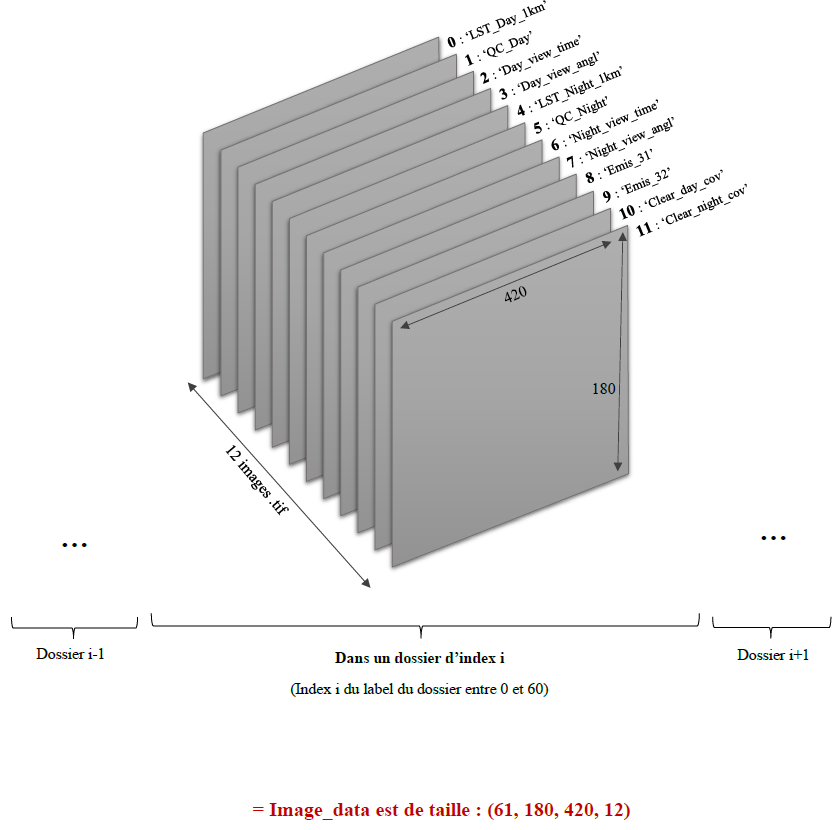

### $\text{Fonction }\color{darkblue}{\textbf{load_dataset}}\text{ - Toutes les données sous forme de tableau}$



In [ ]:
def load_dataset(dataset_dir: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """ Return an array containing all the data from a given access path (dataset_dir) .

    Args: 
        dataset_dir : directory of dataset
    
    Returns:
        The images are converted to an array
        The masks for each images are converted to an array 
        And all the name of folders (containing MODIS images from the given dataset directory) converted to an array (labels)
        
    """
    labels = []
    
    for root, dirs, files in tqdm(os.walk(dataset_dir, topdown=True)): #tqdm is to show the progress status
        if len(dirs) > 1:
            images_data = np.zeros((len(dirs), 180, 420, 12)) # dataset initialisation
            masks = np.zeros((len(dirs), 180, 420))

        if len(files) > 1:
            label_name = root.split(os.sep)[-1]
            labels.append(label_name)
            example_id = len(labels) - 1

        for file_name in files:
            channel_id = get_channel_id(file_name)

            if channel_id is not None:
                file_path = os.path.join(root, file_name)

                image_array = load_file(file_path, channel_id)
                images_data[example_id, :, :, channel_id] = image_array

                mask_array = load_mask(file_path)
                masks[example_id, :, :] = mask_array
                

    labels = np.array(labels)
    return images_data, masks, labels

## $\underline{\color{darkorange}{\text{Création des données d'entrainement et de test}}}$


### $\color{darkcyan}{\text{Cas 1 : Satellites séparés}}$

On possède deux jeux de données : 
- Des données provenant du satellite Acqua
- Des données provenant du satellite Terra

On se propose de charger les données de ces deux satellites, pour l'instant de manière séparée.

In [ ]:
acqua_dir = os.path.join('data', 'Acqua')
terra_dir = os.path.join('data', 'Terra')

images_data_acqua, masks_acqua, labels_acqua = load_dataset(acqua_dir)
images_data_terra, masks_terra, labels_terra = load_dataset(terra_dir)

#Tests
print('Exemple d une donnée image ACQUA :',images_data_acqua[29,:,:,0])
print('Labels du satellite ACQUA :', labels_acqua)
print('Taille des données images ACQUA :', images_data_acqua.shape)
print('Taille des masques à partir des données d ACQUA :', masks_acqua.shape)

print('Exemple d une donnée image TERRA :',images_data_terra[29,:,:,1]) 
print('Labels du satellite TERRA :', labels_terra)
print('Taille des données images TERRA :', images_data_terra.shape)
print('Taille des masques à partir des données de TERRA :', masks_terra.shape)

On créé les données d'entrainement à partir des données du satellite ACQUA et les données de test à part des données du satellite TERRA pour voir si l'algorithme se généralise bien sur différents satellites (angle d'incidente, orbite etc.).

En effet, on aimerai voir si un modèle entrainé sur les données d'un des deux satellite sera performant lors d'un test sur les données de l'autre satellite.

In [ ]:
dataset_split_X_train = images_data_acqua
dataset_split_Y_train = masks_acqua

dataset_split_X_test = images_data_terra
dataset_split_Y_test = masks_terra

# We saved the numpy.ndarray to the .npz format
# This will allow us to load the dataset faster later on
np.savez(
    'dataset_split',
    X_train=dataset_split_X_train,
    Y_train=dataset_split_Y_train,
    X_test=dataset_split_X_test,
    Y_test=dataset_split_Y_test
)
print(f"Dataset sauvegardé dans {os.getcwd()}")

In [ ]:
dataset_split = np.load('dataset_split.npz')
print('Dataset :',dataset_split.files)
print('Exemple - taille de X_train :',dataset_split['X_train'].shape)

### $\color{darkcyan}{\text{Cas 2 : Satellites mélangés}}$

Autre cas de figure, on créé les données d'entrainement et de test à partir des données des satellites ACQUA et TERRA mélangées pour voir si l'algorithme présente des meilleurs performances en s'étant entrainer avec deux jeux de données différents (On suppose que ce sera le cas).

In [ ]:
#Concatenate datasets from the both satellites
images_data = np.concatenate((images_data_acqua, images_data_terra), axis=0 )
labels = np.concatenate((labels_acqua, labels_terra), axis=0)
masks = np.concatenate((masks_acqua, masks_terra), axis=0)

#Test on the concatenated array
print(images_data[59, :, :, 10])
print('Ensemble des labels :', labels)    
print('Taille de images_data :', images_data.shape)
print('Taille des masques :', masks.shape)

Pour cela, on propose de créer des données d'entrainement avec 80 % des données des deux satellites, puis on testera le modèle entrainé sur les 20% restants.
Pour cela on va permuter aléatoirement les dossiers des satellites et prélever les données X et Y (masques associé d'entrainement et de test à partir de ces données.

In [ ]:
from math import ceil
indexes_images_data = np.arange(len(images_data))
#Random permutation of images_data
indexes_permuted = np.random.permutation(indexes_images_data)

# Pick of indices on indexes_permuted to build train and test data
n_train_samples = ceil(80/100*len(indexes_images_data))
indexes_train = indexes_permuted[: n_train_samples]  # With 80% of the indexes of indexes_permuted
indexes_test = indexes_permuted[n_train_samples:]  # With indexes left on indexes_permuted

print('indexes_permuted :',indexes_permuted)
print(ceil(80/100*len(indexes_images_data)))
print('indexes_train :',indexes_train)
print('indexes_test :',indexes_test)

In [ ]:
dataset_mixed_X_train = images_data[indexes_train]
dataset_mixed_Y_train = masks[indexes_train]

dataset_mixed_X_test = images_data[indexes_test]
dataset_mixed_Y_test = masks[indexes_test]

print('Taille dataset_mixed_X_train :', dataset_mixed_X_train.shape)
print('Taille dataset_mixed_Y_train :', dataset_mixed_Y_train.shape)

print('Taille dataset_mixed_X_test :', dataset_mixed_X_test.shape)
print('Taillle dataset_mixed_Y_test :', dataset_mixed_Y_test.shape)

# We saved the numpy.ndarray to the .npz format
# This will allow us to load the dataset faster later on
np.savez(
    'dataset_mixed',
    X_train=dataset_mixed_X_train,
    Y_train=dataset_mixed_Y_train,
    X_test=dataset_mixed_X_test,
    Y_test=dataset_mixed_Y_test
)
print(f"Dataset sauvegardé dans {os.getcwd()}")

In [ ]:
dataset_mixed = np.load('dataset_mixed.npz')
print('Dataset :',dataset_mixed.files)
print('Exemple - taille de X_train :',dataset_mixed['X_train'].shape)

## $\underline{\color{darkorange}{\text{Modele}}}$

In [ ]:
import os
import numpy as np

os.chdir('/content/drive/My Drive/M2/Data Science/LakeNotLake/data')

### $\textbf{Modèle simple pixel par pixel}$



##### $\color{darkred}{\text{Métriques d'évaluation}}$

Comment évaluer un modèle ? 

Le [F-score](https://en.wikipedia.org/wiki/F-score), également appelé *F1-score*, est une mesure de la précision d'un modèle sur un ensemble de données. Il est utilisé pour évaluer les systèmes de **classification binaire**(ici lacs ou pas lacs) et ce score est un moyen de combiner la précision et le rappel du modèle, et il est défini comme la moyenne harmonique de la '*precision*'et du '*recall*' du modèle.

$F_1 = \frac{2}{\text{precision}^{-1}+\text{recall}^{-1}}=\frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}= \frac{\text{Tp}}{Tp + \frac{1}{2}(Fp + Fn)}$


La *'precision'* est le nombre de résultats positifs correctement identifiés divisé par le nombre de tous les résultats positifs, y compris ceux qui ne sont pas correctement identifiés, et le *'recall'* est le nombre de résultats positifs correctement identifiés divisé par le nombre de tous les échantillons qui auraient dû être identifiés comme positifs. La *precision* est également connue sous le nom de valeur prédictive positive, et le *recall* est également connu sous le nom de sensibilité dans la classification binaire diagnostique.

* *[Recall](https://https://en.wikipedia.org/wiki/Precision_and_recall)* = également appelé sensibilité, est la fraction d'exemples classés comme positifs, parmi le nombre total d'exemples positifs. En d'autres termes, le nombre de vrais positifs (Tp) divisé par le nombre de vrais positifs (Tp) plus de faux négatifs (Fn).  

$\text{recall}=\frac{Tp}{Tp+Fn}$

* *[Precision](https:/https://en.wikipedia.org/wiki/Precision_and_recall/)* = est la fraction d'exemples véritablement positifs parmi les exemples que le modèle a classés comme positifs. En d'autres termes, le nombre de vrais positifs (Tp) divisé par le nombre de faux positifs (Fn) plus les vrais positifs (Tp). 

$\text{precision}=\frac{Tp}{Tp+Fp}$

* *[Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision)* = A ne pas confondre avec *precision*.(Pour rappel : l'*accuracy* est la proximité des mesures par rapport à une valeur spécifique, tandis que la *precision* est la proximité des mesures les unes par rapport aux autres.) L'*accuracy* est la proportion de prédictions correctes (à la fois vraies positives (Tp) et vraies négatives (Tn)) parmi le nombre total de cas examinés. 

$\text{accuracy}=\frac{Tp + Tn}{Tp+Fp+Tn+Fn}$

La valeur la plus élevée possible d'un F-score est de 1,0, indiquant une *precision* et un *recall* parfaits, et la valeur la plus basse possible est 0, si la *precision* ou le *recall* est égal à zéro. Le *F1-score* est également connu sous le nom de [coefficient Sørensen – Dice](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) ou coefficient de similarité des dés (DSC).


Remarque :
* Tp = *'True positive'* 
* Tn = *'True negative'*
* Fp = 'False positive'*
* Fn = 'False negative'*


In [ ]:
def accuracy(y_pred, y_true):
    return np.mean(y_pred == y_true)

def get_confusion_data(y_pred, y_true):
    y_true_is_positive = y_true == 1
    true_positives = np.mean(y_pred[y_true_is_positive] == y_true[y_true_is_positive])
    false_negatives = np.mean(y_pred[y_true_is_positive] != y_true[y_true_is_positive])

    y_true_is_negative = np.logical_not(y_true_is_positive)
    true_negatives = np.mean(y_pred[y_true_is_negative] == y_true[y_true_is_negative])
    false_positives = np.mean(y_pred[y_true_is_negative] != y_true[y_true_is_negative])

    return true_positives, false_negatives, true_negatives, false_positives

def recall(y_pred, y_true):
    TP, FN, TN, FP = get_confusion_data(y_pred, y_true)
    return TP / (TP + FN)

def precision(y_pred, y_true):
    TP, FN, TN, FP = get_confusion_data(y_pred, y_true)
    return TP / (TP + FP)

def f1_score(y_pred, y_true):
    TP, FN, TN, FP = get_confusion_data(y_pred, y_true)
    return TP / (TP + (FP + FN)/2)

* Récupérer les noms des caractéristiques et des classes 

In [ ]:
# To reload this function here
def get_name(filename: str) -> str:
    """ Extract variable name from a filename 
    
    Args: 
        filename : character string of the full name of the image

    Returns:
        String containing only the useful name of the image.
    
    """
    post_name = filename.split('1km_LST_')[-1]
    return ' '.join(post_name.split('_')[:-1])

In [ ]:
acqua_example_path = os.path.join('data', 'Acqua', 'MODIS', '39162', '2236585057')  
features_names = [
    get_name(filename) for filename in os.listdir(acqua_example_path)
    if filename.endswith('.tif')
]
labels = ['NotLake', 'Lake']

#### $\color{darkcyan}{\text{Cas 1 : Satellites séparés}}$

In [ ]:
# Load the data 
dataset = np.load('dataset_split.npz')

X_train = dataset['X_train']
Y_train = dataset['Y_train']
X_test = dataset['X_test']
Y_test = dataset['Y_test']

##### - $\text{Réduction des dimensions des données}$

On applatit les images pour réduire les dimensions des données et faciliter l'apprentissage de nos modèles (pour extraire les données).
Pour cela on écrase ensemble les dimensions des dossiers, de la largeur et la hauteur des images en gardant les douzes composantes différentes pour chaque pixel.


In [ ]:
print('Dimensions initiales de X_train:', X_train.shape)
print('Dimensions initiales de Y_train:', Y_train.shape)

X_train_pixels = X_train.reshape((-1, 12))
Y_train_pixels = Y_train.ravel() # Be careful of the order !

X_test_pixels = X_test.reshape((-1, 12))
Y_test_pixels = Y_test.ravel()

print('Dimensions finales de X_train_pixels:', X_train_pixels.shape)
print('Dimensions finales de Y_train_pixels:', Y_train_pixels.shape)

* Voyons la proportion de pixels de lacs qu'il y a sur l'ensemble de nos données d'entrainement :

In [ ]:
n_pixels_lacs_train = np.sum(Y_train_pixels == 1)
lac_percentage = 100 * n_pixels_lacs_train / len(Y_train_pixels)
print(f"Le pourcentage de pixels de lacs dans les données d'entrainement est de {lac_percentage:.3f}%")

Ce pourcentage est très faible, on se demandera plus tard dans l'entrainement du modèle s'il ne serait pas intéressant d'ajouter un poids (*weight*) aux pixels de lacs pour entrainer notre modèle. En effet, les pixels de lacs ont un grand intérêt pour nous et comparé aux pixels qui ne sont pas des lacs.

##### $\textbf{SupportVectorClassifier (SVC)}$

Pour rappel, *SVC* est un type de modèle utilisant une méthode d'apprentissage supervisée pour la classification, la régression et la détection des valeurs aberrantes. Il permet notamment de travailler avec des espaces à grandes dimensions.

Or il nous faudrait un modèle qui peut gérer un grand nombre de données (ici 2,26 millions de données), ce qui n'est pas le cas du *Classifier SVC*. 
En lançant un modèle *SVC*, ce modèle peine donc à s'entrainer...

Nous tentons alors, dans un premier temps, avec le modèle RandomForest qui semble fonctionner.


##### $\textbf{ RandomForest}$

Pour rappel, *RandomForest* est un méta-estimateur qui ajuste un certain nombre d'arbres de décision - classificateurs sur divers sous-échantillons de l'ensemble de données et utilise la moyenne pour améliorer la précision prédictive et contrôler le sur-ajustement (*over-fitting*).

L'intérêt d'utiliser ce modèle est qu'il peut s'appuie sur beaucoup de données et de plus sur des données non structurées (comme c'est le cas ici, avec nos douzes valeurs des pixels).

Voici quelques hyper-paramètres intéressants de *RandomForest* : 

* *n_estimators* : nombre de d'arbres. Par indication, il s'agit d'un entier pouvant varier entre 10 et 100.  

* *max_depth* : Il s'agit de la profondeur maximale de l'arbre de décision du modèle. 

* *class_weight* : Poids associés aux classes sous la forme {class_label: weight}. A priori, cet hyper-paramètre peut être utile pour ajouter du poids à notre classe "pixels de lacs" qui est plus importante que l'ensemble des pixels qui ne sont pas des lacs. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

Pour trouver les meilleurs hyperparamètres de ce modèle, on propose d'utiliser un outil en ligne conçu pour suivre, comparer et visualiser des expériences de Machine Learning : **[Weights & Biases](https://wandb.ai/site)** (wandb). 

Cet outil, très utile, permet le suivi des expériences, l'optimisation des hyperparamètres, la gestion des versions des modèles et des ensembles de données.

In [ ]:
!pip install wandb --quiet

Voici un dictionnaire définissant notre modèle, où on propose plusieurs gamme de validité des hyperparamètres du modèle. En effet, nous ne savons pas quelles sont les meilleures valeurs d'hyperparamètres et nous allons essayer de les estimer avec wandb en lançant plusieurs *runs*. 

In [ ]:
import wandb

sweep_config = {
  "name": "My Sweep",
  "method": "random",
  "metric": "f1_score",
  "goal": "maximize",
  "parameters": {
        "model": {
            "value": "RandomForestClassifier"
        },
        "n_estimators": {
            "distribution": "q_log_uniform",
            "min": 0,
            "max": 5,
            "q": 1,
        },
        "max_depth": {
            "distribution": "int_uniform",
            "min": 2,
            "max": 15,
        },
        "lake_pixel_weight": {
            "distribution": "q_log_uniform",
            "min": 0,
            "max": 7.6,
            "q": 1,
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="LakeNotLake")

* $\text{Obtention des meilleurs hyperparamètres du modèle entrainé à partir des données de validation}$

L’un des problèmes fondamentaux d’un apprentissage supervisé est d’éviter l’effet dit d’overfitting (ou de surapprentissage) qui se manifeste lorsqu’à force d’entraînement un jeu de règles se révèle parfaitement adapté aux données déjà observées mais ne conduit cependant à aucune généralisation utile. Des parades ont été élaborées par les data scientists pour se prémunir contre cet écueil. Pour partie, elles consistent à répartir astucieusement les données expérimentales en données d’apprentissage d’une part et en données de validation d’autre part.
On décide donc de séparer nos données initiales d'entrainement (issues du satellite Acqua) en données d'entrainement d'une part et en données de validation d'autre part (sur lesquelles on va tester notre modèle entrainé avec les données d'entrainement). On choisit de couper en 5 parties (*n_fold*) nos données initiales d'entrainement.





In [ ]:
import wandb
import time

def train(n_fold=5, metrics=('accuracy', 'recall', 'precision', 'f1_score')):
    run = wandb.init(project="LakeNotLake")
    config = dict(run.config)

    lake_pixel_weight = config.pop('lake_pixel_weight', 1)
    class_weight = {0:1, 1:lake_pixel_weight}
    print("Config:", config)

    all_index = np.arange(len(Y_train_pixels))
    indexes_permuted = np.random.permutation(all_index)
    val_indexes_list = np.array_split(indexes_permuted, n_fold)

    train_metrics = {metric_name: [] for metric_name in metrics}
    val_metrics = {metric_name: [] for metric_name in metrics}

    model_class = eval(config.pop('model'))

    for i in range(n_fold):
        print(f"Fold {i}:")
        #Separate train et val
        val_index = val_indexes_list[i]
        train_index = np.delete(indexes_permuted, val_index)

        x_train, y_train = X_train_pixels[train_index], Y_train_pixels[train_index]
        x_val, y_val = X_train_pixels[val_index], Y_train_pixels[val_index]

        model = model_class(class_weight=class_weight, **config)

        t0 = time.time()
        model.fit(x_train, y_train)
        training_time = time.time() - t0
        
        y_pred_train = model.predict(x_train)
        y_pred_val = model.predict(x_val)
        for metric_name in metrics:
            metric = eval(metric_name)
            train_value = metric(y_pred_train, y_train)
            val_value = metric(y_pred_val, y_val)
            print(f"\t{metric_name} - train:{train_value:.4f} val:{val_value:.4f}")
            train_metrics[metric_name].append(train_value)
            val_metrics[metric_name].append(val_value)
        
        for f1_val in val_metrics['f1_score']:
            if f1_val < 0.9:
                return

    print(metrics)
    for metric_name in metrics:
        mean_value_train = np.mean(train_metrics[metric_name])
        mean_value_val = np.mean(val_metrics[metric_name])
    
        std_value_train = np.std(train_metrics[metric_name])
        std_value_val = np.std(val_metrics[metric_name])

        print(f"{metric_name}:  \t {mean_value_train:.4f}±{std_value_train:.4f}")
        print(f"{'val_' + metric_name}:  \t {mean_value_val:.4f}±{std_value_val:.4f}")

        wandb.log({metric_name: mean_value_train}, commit=False)
        wandb.log({'val_' + metric_name: mean_value_val}, commit=False)

    wandb.log({'training_time': training_time})
    wandb.sklearn.plot_feature_importances(model, features_names)

wandb.agent(sweep_id, function=train)

$\underline{\text{Remarque de la sortie ci-dessus :}}$ on remarque que le 'recall' est en général la métrique la plus basse, ce qui signifie que le modèle a prédit des faux négatifs (il a prédit que certains pixels de lacs n'en sont pas). Le modèle est donc légèrement biaisé à prédire que les pixels ne sont pas des lacs, ce qui est normal vu la distribution des données.
>

$\underline{\color{darkred}{\textbf{RESULTATS :}}}$
(Graphiques dynamiques sur Wandb:)

https://wandb.ai/camillever/LakeNotLake/reports/Project-LakeNotLake---Vmlldzo1MTQ2Njk?accessToken=gs6g0ftsnlab9k4tw712hneau3o5v3mgba64leytr38lc85av80aq50ju9hzunfw


$\underline{\text{Prévisualisation d'un graphique issu du lien Wandb fourni ci-dessus :}}$
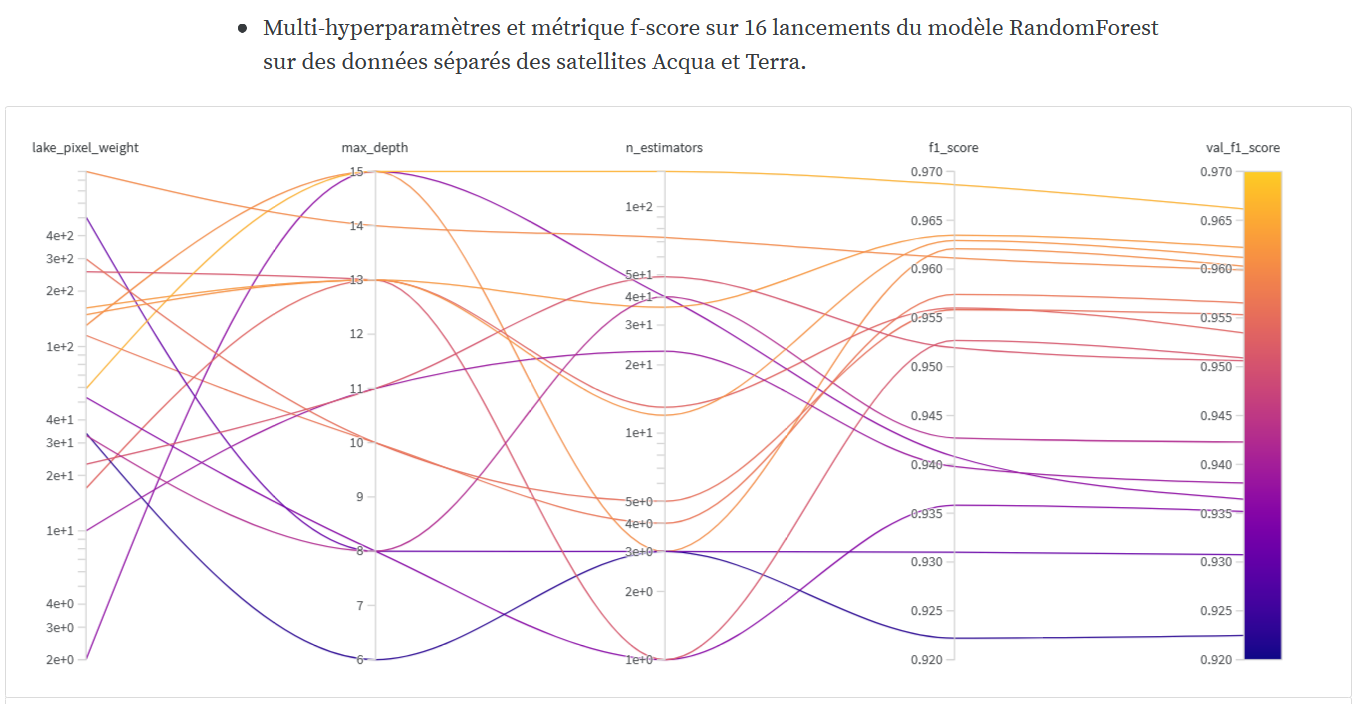




* $\underline{\text{Vérification des hyperparamètres les plus adaptées à l'application aux données de test}}$

In [ ]:
def evaluate(model):
    model.fit(X_train_pixels, Y_train_pixels)

    y_pred_train = model.predict(X_train_pixels)
    y_pred_test = model.predict(X_test_pixels)

    for metric_name in ['accuracy', 'precision', 'recall', 'f1_score']:
        metric = eval(metric_name)  # Transform str to var
        train_value = metric(y_pred_train, Y_train_pixels)
        test_value = metric(y_pred_test, Y_test_pixels)
        print(f"\t{metric_name} - train:{train_value:.4f} test:{test_value:.4f}")


model = RandomForestClassifier(
    verbose=1,
    n_estimators=150,
    max_depth=7,
    class_weight={0:1, 1:100},
    n_jobs=-1,
)
evaluate(model)

En testant notre modèle avec les hyperparamètres les plus performants lors du test des données de validation (59 de lake_pixel_weight, 15 de max_depth et 143 de n_estimators) sur les données de test, on observe un très fort overfitting d'après la métrique f-score :
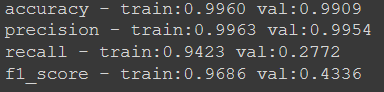
*remarque : ce n'est pas 'val' mais 'test'.


Cette expérience nous montre bien que faire un test sur les données d'un autre satellite nécessite de choisir des hyperparamètres pas trop performants lors de 'runs de validation' car sinon l'algorithme va trop apprendre à "coller" aux données et ne pas réussir à discerner les pixels de lacs des autres sur les données d'un autre satellite!


On choisit donc des hyperparamètres pour des 'runs' sur les données de validation moins bonnes pour empêcher l'overfitting sur les données de test. On a choisit, après plusieurs essais, les hyperparamètres définis précédemment dans les arguments du modèle *RandomForestClassifier*. 
On n'observe plus d'overfitting ! Et on obtient un f-score sur les données test (du satellite Terra) plutôt très satisfaisant!
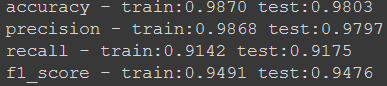

On peut alors conclure que l'on obtient un bon moyen de discerner un pixel de lac d'un autre pixel avec le modèle RandomForest avec un seul jeu de données d'entrainement d'un satellite pour l'appliquer à des données test d'un autre satellite. 
Le choix des hyperparamètres est un processus plutôt compliqué et nécessite plusieurs essais pour vérifier que notre modèle ne surestime pas (overfitting) et soit incapable d'être performant avec de nouvelles données légèrement différentes (d'un autre satellite : angle d'incidence différente etc.) Or ici avec 94% de f-score en test, on prouve que la différence d'angle d'acquisition des images ne semble finalement pas déroutant pour notre modèle.


#### $\color{darkcyan}{\text{Cas 2 : Satellites mélangés}}$

In [ ]:
# Load the data 
dataset = np.load('dataset_mixed.npz')

X_train = dataset['X_train']
Y_train = dataset['Y_train']
X_test = dataset['X_test']
Y_test = dataset['Y_test']

##### - $\text{Réduction des dimensions des données}$

On applatit les images pour réduire les dimensions des données et faciliter l'apprentissage de nos modèles (pour extraire les données).
Pour cela on écrase ensemble les dimensions des dossiers, de la largeur et la hauteur des images en gardant les douzes composantes différentes pour chaque pixel.


In [ ]:
print('Dimensions initiales de X_train:', X_train.shape)
print('Dimensions initiales de Y_train:', Y_train.shape)

X_train_pixels = X_train.reshape((-1, 12))
Y_train_pixels = Y_train.ravel() # Be careful of the order !

X_test_pixels = X_test.reshape((-1, 12))
Y_test_pixels = Y_test.ravel()

print('Dimensions finales de X_train_pixels:', X_train_pixels.shape)
print('Dimensions finales de Y_train_pixels:', Y_train_pixels.shape)

##### $\textbf{ RandomForest}$

Pour rappel, *RandomForest* est un méta-estimateur qui ajuste un certain nombre d'arbres de décision - classificateurs sur divers sous-échantillons de l'ensemble de données et utilise la moyenne pour améliorer la précision prédictive et contrôler le sur-ajustement (*over-fitting*).

L'intérêt d'utiliser ce modèle est qu'il peut s'appuie sur beaucoup de données et de plus sur des données non structurées (comme c'est le cas ici, avec nos douzes valeurs des pixels).

Voici quelques hyper-paramètres intéressants de *RandomForest* : 

* *n_estimators* : nombre de d'arbres. Par indication, il s'agit d'un entier pouvant varier entre 10 et 100.  

* *max_depth* : Il s'agit de la profondeur maximale de l'arbre de décision du modèle. 

* *class_weight* : Poids associés aux classes sous la forme {class_label: weight}. A priori, cet hyper-paramètre peut être utile pour ajouter du poids à notre classe "pixels de lacs" qui est plus importante que l'ensemble des pixels qui ne sont pas des lacs. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

Pour trouver les meilleurs hyperparamètres de ce modèle, on propose d'utiliser un outil en ligne conçu pour suivre, comparer et visualiser des expériences de Machine Learning : **[Weights & Biases](https://wandb.ai/site)** (wandb). 

Cet outil, très utile, permet le suivi des expériences, l'optimisation des hyperparamètres, la gestion des versions des modèles et des ensembles de données.

In [ ]:
!pip install wandb --quiet

Voici un dictionnaire définissant notre modèle, où on propose plusieurs gamme de validité des hyperparamètres du modèle. En effet, nous ne savons pas quelles sont les meilleures valeurs d'hyperparamètres et nous allons essayer de les estimer avec wandb en lançant plusieurs *runs*. 

In [ ]:
import wandb

sweep_config = {
  "name": "My Sweep-val-mixed_data",
  "method": "random",
  "metric": "f1_score",
  "goal": "maximize",
  "parameters": {
        "model": {
            "value": "RandomForestClassifier"
        },
        "n_estimators": {
            "distribution": "q_log_uniform",
            "min": 0,
            "max": 5,
            "q": 1,
        },
        "max_depth": {
            "distribution": "int_uniform",
            "min": 2,
            "max": 15,
        },
        "lake_pixel_weight": {
            "distribution": "q_log_uniform",
            "min": 0,
            "max": 7.6,
            "q": 1,
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="LakeNotLake")

* $\text{Obtention des meilleurs hyperparamètres du modèle entrainé à partir des données de validation}$

L’un des problèmes fondamentaux d’un apprentissage supervisé est d’éviter l’effet dit d’overfitting (ou de surapprentissage) qui se manifeste lorsqu’à force d’entraînement un jeu de règles se révèle parfaitement adapté aux données déjà observées mais ne conduit cependant à aucune généralisation utile. Des parades ont été élaborées par les data scientists pour se prémunir contre cet écueil. Pour partie, elles consistent à répartir astucieusement les données expérimentales en données d’apprentissage d’une part et en données de validation d’autre part.
On choisit de couper en 5 parties (*n_fold*) nos données initiales d'entrainement, comme précédemment.





In [ ]:
import wandb
import time

def train(n_fold=5, metrics=('accuracy', 'recall', 'precision', 'f1_score')):
    run = wandb.init(project="LakeNotLake")
    config = dict(run.config)

    lake_pixel_weight = config.pop('lake_pixel_weight', 1)
    class_weight = {0:1, 1:lake_pixel_weight}
    print("Config:", config)

    all_index = np.arange(len(Y_train_pixels))
    indexes_permuted = np.random.permutation(all_index)
    val_indexes_list = np.array_split(indexes_permuted, n_fold)

    train_metrics = {metric_name: [] for metric_name in metrics}
    val_metrics = {metric_name: [] for metric_name in metrics}

    model_class = eval(config.pop('model'))

    for i in range(n_fold):
        print(f"Fold {i}:")
        #Separate train et val
        val_index = val_indexes_list[i]
        train_index = np.delete(indexes_permuted, val_index)

        x_train, y_train = X_train_pixels[train_index], Y_train_pixels[train_index]
        x_val, y_val = X_train_pixels[val_index], Y_train_pixels[val_index]

        model = model_class(class_weight=class_weight, **config)

        t0 = time.time()
        model.fit(x_train, y_train)
        training_time = time.time() - t0
        
        y_pred_train = model.predict(x_train)
        y_pred_val = model.predict(x_val)
        for metric_name in metrics:
            metric = eval(metric_name)
            train_value = metric(y_pred_train, y_train)
            val_value = metric(y_pred_val, y_val)
            print(f"\t{metric_name} - train:{train_value:.4f} val:{val_value:.4f}")
            train_metrics[metric_name].append(train_value)
            val_metrics[metric_name].append(val_value)
        
        for f1_val in val_metrics['f1_score']:
            if f1_val < 0.9:
                return

    print(metrics)
    for metric_name in metrics:
        mean_value_train = np.mean(train_metrics[metric_name])
        mean_value_val = np.mean(val_metrics[metric_name])
    
        std_value_train = np.std(train_metrics[metric_name])
        std_value_val = np.std(val_metrics[metric_name])

        print(f"{metric_name}:  \t {mean_value_train:.4f}±{std_value_train:.4f}")
        print(f"{'val_' + metric_name}:  \t {mean_value_val:.4f}±{std_value_val:.4f}")

        wandb.log({metric_name: mean_value_train}, commit=False)
        wandb.log({'val_' + metric_name: mean_value_val}, commit=False)

    wandb.log({'training_time': training_time})
    wandb.sklearn.plot_feature_importances(model, features_names)

wandb.agent(sweep_id, function=train)

$\underline{\color{darkred}{\text{Résultats :}}}$ (lien à graphique dynamique)

https://wandb.ai/camillever/LakeNotLake/reports/-Projet-LakeNotLake---Vmlldzo1MTk2Njg?accessToken=c1v43gj3fgbpejkr7v83xhxjffzkl8v7h3wz215cx9ruxq0yfa0bhfz83q317tqk

Prévisualisation d'un des graphiques du lien fourni ci-dessus : 
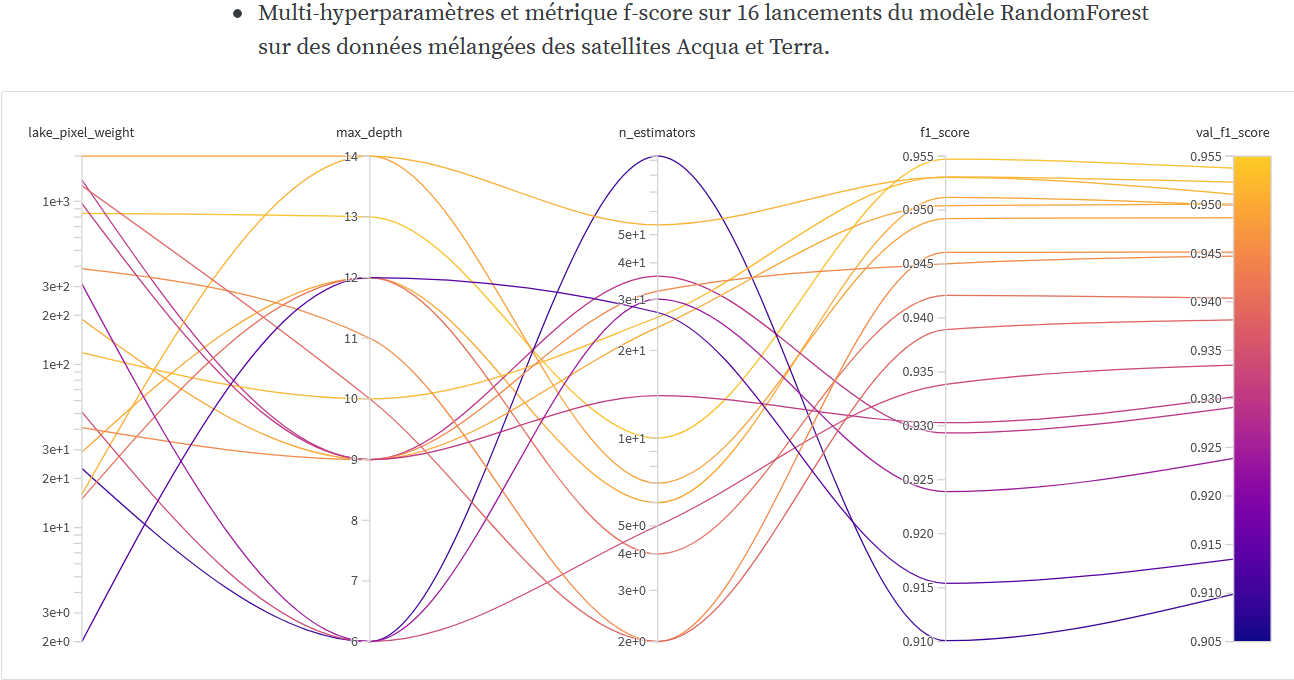

* $\underline{\text{Vérification des hyperparamètres les plus adaptées à l'application aux données de test}}$

In [ ]:
def evaluate(model):
    model.fit(X_train_pixels, Y_train_pixels)

    y_pred_train = model.predict(X_train_pixels)
    y_pred_test = model.predict(X_test_pixels)

    for metric_name in ['accuracy', 'precision', 'recall', 'f1_score']:
        metric = eval(metric_name)  # Transform str to var
        train_value = metric(y_pred_train, Y_train_pixels)
        test_value = metric(y_pred_test, Y_test_pixels)
        print(f"\t{metric_name} - train:{train_value:.4f} test:{test_value:.4f}")


model = RandomForestClassifier(
    verbose=1,
    n_estimators=150,
    max_depth=7,
    class_weight={0:1, 1:100},
    n_jobs=-1,
)
evaluate(model)

On obtient après plusieurs essais d'hyperparamètres de lancements précédents qui avaient bien marché et on trouve des hyperparamètres plutôt satisfaisants et qui fournit un modèle ayant plus **97% de f1-score !**

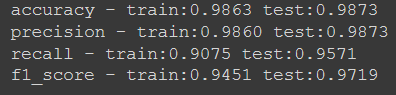

Il s'agit d'ailleurs des mêmes hyperparamètres que pour les données test des satellites séparées, on peut donc voir que comme on si était entendu, un modèle sera donc performant s'il s'est entrainé avec des jeux de données similaires aux jeux de données de test (ce qui est notre cas ici avec les données mélangés). Cependant si on décidait d'ajouter un nouveau jeux de données provenant d'un autre satellite, l'algorithme se comportera aussi comme le Cas 1 (satellites séparés) lors d'un test et il y aura des effets d'overfitting. C'est pourquoi il est très important de savoir choisir ses hyperparamètres sur des 'runs' performantes mais pas trop !

## $\color{red}{\text{Conclusion}}$

* RandomForest est un modèle satisfaisant pour notre projet à classification binaire et ce modèle a été plutôt très performant!

* L'ajout de 'Expert Features' comme la différence Jour-nuit n'a pas été nécessaire (mais c'est possible de l'ajouter par contre)

* **On obtient des f-score de plus de 94% sur des jeux de données séparées et plusde 97% sur des jeux de données mélangées.** (Cohérent avec nos attentes)

* Les lancements du modèle a pu montré que parmi les hyperparamètres, l'ajout d'un poids aux pixels de lacs est très conseillé pour améliorer les performances de notre modèle

* Le f-score est un métrique très adapté à ce type de projet à classification binaire contrairement à .score renvoyant un simple 'accuracy' qui ne reflète pas la sensibilité (*recall*) et à quel point le modèle a réussi à déterminer que les pixels de lacs prédits sont bien des lacs (*precision*).

